In [281]:
import os
import gc
import math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, classification_report

pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


In [282]:
DATA_DIR = Path("114239_nfl_competition_files_published_analytics_final").expanduser()
OUTPUT_DIR = Path('.').expanduser()

WEEKS_TO_LOAD = sorted({int(fp.stem.split('_')[-1][1:]) for fp in (DATA_DIR / "train").glob('input_*.csv')})
MAX_FRAMES_PER_WEEK = None

DATA_DIR = DATA_DIR.resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_DIR = DATA_DIR / "train"
SUPPLEMENTARY_PATH = DATA_DIR / "supplementary_data.csv"

print(f"DATA_DIR resolved to: {DATA_DIR}")
print(f"TRAIN_DIR exists: {TRAIN_DIR.exists()} with {len(list(TRAIN_DIR.glob('input_*.csv')))} weekly input files")
if MAX_FRAMES_PER_WEEK:
    print(f"Limiting to the first {MAX_FRAMES_PER_WEEK} rows per week to keep runtime manageable.")


DATA_DIR resolved to: /Users/prabhleenkaur/Desktop/ECE225-NFL/114239_nfl_competition_files_published_analytics_final
TRAIN_DIR exists: True with 18 weekly input files


In [283]:
import warnings
warnings.filterwarnings("ignore")

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def normalize_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace("-", "_")
        .str.replace(" ", "_")
    )
    return df

def infer_week_from_path(fp):
    tokens = Path(fp).stem.split("_")
    week_token = next((tok for tok in tokens if tok.lower().startswith('w')), None)
    if week_token:
        try:
            return int(week_token.lower().replace('w', ''))
        except ValueError:
            return None
    return None

def load_weekly_csvs(prefix, weeks=None, limit=None):
    if not TRAIN_DIR.exists():
        return pd.DataFrame()
    if weeks:
        candidates = [TRAIN_DIR / f"{prefix}_2023_w{w:02d}.csv" for w in weeks]
    else:
        candidates = sorted(TRAIN_DIR.glob(f"{prefix}_*.csv"))
    frames = []
    for fp in candidates:
        if not Path(fp).exists():
            continue
        df = pd.read_csv(fp, low_memory=False)
        df['week'] = infer_week_from_path(fp)
        if limit:
            df = df.head(limit)
        frames.append(df)
    if frames:
        return pd.concat(frames, ignore_index=True)
    return pd.DataFrame()


# Local files are organized as:
- supplementary_data.csv: play-level context + EPA.
- train/input_2023_wXX.csv: player tracking frames & metadata per week.
- train/output_2023_wXX.csv: ball landing coordinates for the tracked target.

In [284]:
if not DATA_DIR.exists():
    raise FileNotFoundError(f"{DATA_DIR} does not exist. Update DATA_DIR to the release folder.")

input_files = sorted(TRAIN_DIR.glob("input_*.csv"))
output_files = sorted(TRAIN_DIR.glob("output_*.csv"))

print(f"Supplementary data located at: {SUPPLEMENTARY_PATH} (exists={SUPPLEMENTARY_PATH.exists()})")
print(f"Player frame inputs: {len(input_files)} csv files")
print(f"Ball landing outputs: {len(output_files)} csv files")
for fp in input_files[:5]:
    print(" -", fp.name)

if WEEKS_TO_LOAD:
    print(f"Configured to load weeks: {WEEKS_TO_LOAD}")
else:
    print("Configured to load every available week (may be slow).")


Supplementary data located at: /Users/prabhleenkaur/Desktop/ECE225-NFL/114239_nfl_competition_files_published_analytics_final/supplementary_data.csv (exists=True)
Player frame inputs: 18 csv files
Ball landing outputs: 18 csv files
 - input_2023_w01.csv
 - input_2023_w02.csv
 - input_2023_w03.csv
 - input_2023_w04.csv
 - input_2023_w05.csv
Configured to load weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


# Data overview
This notebook inspects the local release folder, loads the supplementary/weekly tracking CSVs, and then derives analysis tables.

In [285]:
dfs = {}

if SUPPLEMENTARY_PATH.exists():
    plays = normalize_columns(pd.read_csv(SUPPLEMENTARY_PATH, low_memory=False))
    dfs['plays'] = plays
else:
    plays = pd.DataFrame()
    print("Warning: supplementary_data.csv was not found at", SUPPLEMENTARY_PATH)

tracking = load_weekly_csvs('input', weeks=WEEKS_TO_LOAD, limit=MAX_FRAMES_PER_WEEK)
if not tracking.empty:
    tracking = normalize_columns(tracking)
    rename_map = {
        'nfl_id': 'player_id',
        'player_name': 'displayName',
        'player_position': 'position',
        'player_side': 'team'
    }
    tracking = tracking.rename(columns={k: v for k, v in rename_map.items() if k in tracking.columns})
    if 'player_to_predict' in tracking.columns:
        tracking['player_to_predict'] = tracking['player_to_predict'].astype(bool)
    dfs['tracking'] = tracking
else:
    tracking = pd.DataFrame()
    print("Tracking inputs are empty for the requested configuration.")

ball_targets = load_weekly_csvs('output', weeks=WEEKS_TO_LOAD, limit=MAX_FRAMES_PER_WEEK)
if not ball_targets.empty:
    ball_targets = normalize_columns(ball_targets)
    if 'nfl_id' in ball_targets.columns:
        ball_targets = ball_targets.rename(columns={'nfl_id': 'player_id'})
    dfs['ball_targets'] = ball_targets
else:
    ball_targets = pd.DataFrame()
    print("Ball landing outputs are empty for the requested configuration.")

if not tracking.empty:
    player_cols = ['player_id', 'displayName', 'position', 'player_height', 'player_weight', 'player_birth_date', 'team', 'player_role']
    available_cols = [c for c in player_cols if c in tracking.columns]
    if available_cols and 'player_id' in available_cols:
        players = tracking[available_cols].drop_duplicates(subset='player_id')
    else:
        players = pd.DataFrame()
else:
    players = pd.DataFrame()

dfs['players'] = players

if not plays.empty:
    game_cols = ['game_id', 'season', 'week', 'home_team_abbr', 'visitor_team_abbr', 'game_date']
    available_game_cols = [c for c in game_cols if c in plays.columns]
    if available_game_cols and 'game_id' in available_game_cols:
        games = plays[available_game_cols].drop_duplicates(subset='game_id')
    else:
        games = pd.DataFrame()
else:
    games = pd.DataFrame()

dfs['games'] = games


In [286]:
if not tracking.empty:
    # normalize naming quirks
    if 'position' not in tracking.columns and 'player_position' in tracking.columns:
        tracking = tracking.rename(columns={'player_position': 'position'})
    pos_col = 'position' if 'position' in tracking.columns else None

    if pos_col is None and not players.empty and 'player_id' in players.columns:
        pos_lookup = players[['player_id', 'position']].drop_duplicates('player_id')
        tracking = tracking.merge(pos_lookup, on='player_id', how='left', suffixes=('', '_player_meta'))
        if 'position_player_meta' in tracking.columns:
            tracking['position'] = tracking['position_player_meta']
            tracking = tracking.drop(columns=['position_player_meta'])
            pos_col = 'position'

    if pos_col is None:
        tracking['position'] = 'UNKNOWN'
        pos_col = 'position'

    tracking['position'] = tracking['position'].fillna('UNKNOWN')
else:
    print('Tracking empty -> skipping position normalization')


In [287]:
for k,v in dfs.items():
    print(k, v.shape)
    display(v.head(2))

plays (18009, 41)


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,game_clock,down,yards_to_go,possession_team,defensive_team,yardline_side,yardline_number,pre_snap_home_score,pre_snap_visitor_score,play_nullified_by_penalty,pass_result,pass_length,offense_formation,receiver_alignment,route_of_targeted_receiver,play_action,dropback_type,dropback_distance,pass_location_type,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,10:46,3,12,DET,KC,DET,23,20,14,N,C,18,EMPTY,3x2,IN,False,TRADITIONAL,5.30,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,07:30,1,10,DET,KC,DET,34,0,0,N,C,13,SINGLEBACK,3x1,POST,True,TRADITIONAL,4.72,INSIDE_BOX,7,ZONE_COVERAGE,COVER_6_ZONE,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415


tracking (4880579, 24)


,game_id,play_id,player_to_predict,player_id,frame_id,play_direction,absolute_yardline_number,displayName,player_height,player_weight,player_birth_date,position,team,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22,1
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22,1


ball_targets (562936, 7)


,game_id,play_id,player_id,frame_id,x,y,week
0,2023090700,101,46137,1,56.22,17.28,1
1,2023090700,101,46137,2,56.63,16.88,1


players (1384, 8)


,player_id,displayName,position,player_height,player_weight,player_birth_date,team,player_role
0,54527,Bryan Cook,FS,6-1,210,1999-09-07,Defense,Defensive Coverage
26,46137,Justin Reid,SS,6-1,204,1997-02-15,Defense,Defensive Coverage


games (349, 6)


,game_id,season,week,home_team_abbr,visitor_team_abbr,game_date
0,2023090700,2023,1,KC,DET,09/07/2023
58,2023091000,2023,1,ATL,CAR,09/10/2023


# DATA DICTIONARY & EXPLAINER
Key tables
- `plays` — derived from `supplementary_data.csv`; contains EPA, pass result, route metadata, clock state, etc.
- `tracking` — concatenated from weekly `train/input_2023_wXX.csv` files; every row is a player-frame (x, y, s, a, dir, metadata).
- `ball_targets` — concatenated from `train/output_2023_wXX.csv`; positional targets aligned to tracking frames for the player we must predict.
- `players` — deduplicated player metadata extracted from the tracking inputs.
- `games` — subset of play-level columns describing game context (season/week/home/visitor).

In [288]:
plays = dfs.get('plays', pd.DataFrame()).copy()
tracking = dfs.get('tracking', pd.DataFrame()).copy()
players = dfs.get('players', pd.DataFrame()).copy()
games = dfs.get('games', pd.DataFrame()).copy()

print("plays columns:", plays.columns.tolist()[:30])
print("tracking columns:", tracking.columns.tolist()[:30])

plays columns: ['game_id', 'season', 'week', 'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr', 'play_id', 'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go', 'possession_team', 'defensive_team', 'yardline_side', 'yardline_number', 'pre_snap_home_score', 'pre_snap_visitor_score', 'play_nullified_by_penalty', 'pass_result', 'pass_length', 'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver', 'play_action', 'dropback_type', 'dropback_distance', 'pass_location_type', 'defenders_in_the_box']
tracking columns: ['game_id', 'play_id', 'player_to_predict', 'player_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'displayName', 'player_height', 'player_weight', 'player_birth_date', 'position', 'team', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week']


In [289]:
def missing_summary(df, name):
    miss = df.isna().mean().sort_values(ascending=False)
    print(f"--- {name} missing (top 20) ---")
    display(miss.head(20))
    
missing_summary(plays, "plays")
missing_summary(tracking, "tracking")
missing_summary(players, "players")

--- plays missing (top 20) ---


penalty_yards                            0.974457
yardline_side                            0.013937
pass_location_type                       0.001111
team_coverage_type                       0.000278
team_coverage_man_zone                   0.000278
route_of_targeted_receiver               0.000222
play_action                              0.000056
dropback_type                            0.000056
dropback_distance                        0.000056
receiver_alignment                       0.000000
defenders_in_the_box                     0.000000
game_id                                  0.000000
pass_length                              0.000000
pre_penalty_yards_gained                 0.000000
yards_gained                             0.000000
expected_points                          0.000000
expected_points_added                    0.000000
pre_snap_home_team_win_probability       0.000000
pre_snap_visitor_team_win_probability    0.000000
home_team_win_probability_added          0.000000


--- tracking missing (top 20) ---


game_id                     0.0
play_id                     0.0
ball_land_y                 0.0
ball_land_x                 0.0
num_frames_output           0.0
o                           0.0
dir                         0.0
a                           0.0
s                           0.0
y                           0.0
x                           0.0
player_role                 0.0
team                        0.0
position                    0.0
player_birth_date           0.0
player_weight               0.0
player_height               0.0
displayName                 0.0
absolute_yardline_number    0.0
play_direction              0.0
dtype: float64

--- players missing (top 20) ---


player_id            0.0
displayName          0.0
position             0.0
player_height        0.0
player_weight        0.0
player_birth_date    0.0
team                 0.0
player_role          0.0
dtype: float64

# Basic stats


In [290]:
if not plays.empty:
    display(plays.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
game_id,18009.0,NaN,NaN,NaN,2023407015.121717,538158.057924,2023090700.0,2023101506.0,2023112604.0,2024010701.0,2025010515.0
season,18009.0,NaN,NaN,NaN,2023.216614,0.411949,2023.0,2023.0,2023.0,2023.0,2024.0
week,18009.0,NaN,NaN,NaN,10.880726,5.45352,1.0,6.0,12.0,16.0,18.0
game_date,18009,73,09/24/2023,733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_time_eastern,18009,13,13:00:00,8758,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_team_abbr,18009,32,MIN,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitor_team_abbr,18009,32,NO,680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
play_id,18009.0,NaN,NaN,NaN,2195.70276,1252.668653,54.0,1137.0,2170.0,3257.0,5258.0
play_description,18009,18005,(8:55) (Shotgun) S.Howell pass incomplete shor...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quarter,18009.0,NaN,NaN,NaN,2.581043,1.121554,1.0,2.0,3.0,4.0,5.0


# PLAY-LEVEL DISTRIBUTIONS
Supplementary data captures pass-result outcomes and the targeted receiver's route.
Visualizing these first provides context for the frame-level analysis below.

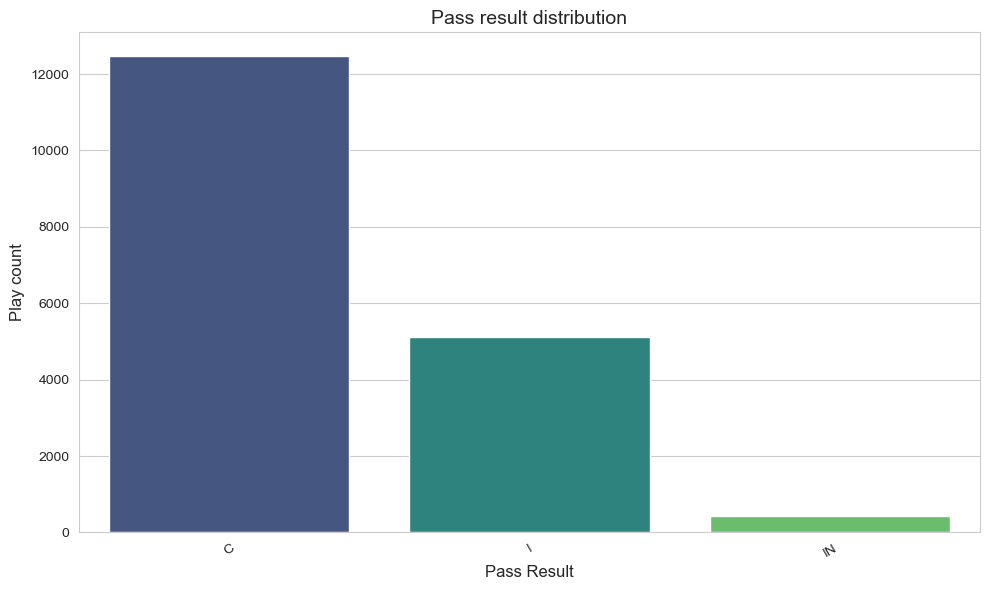

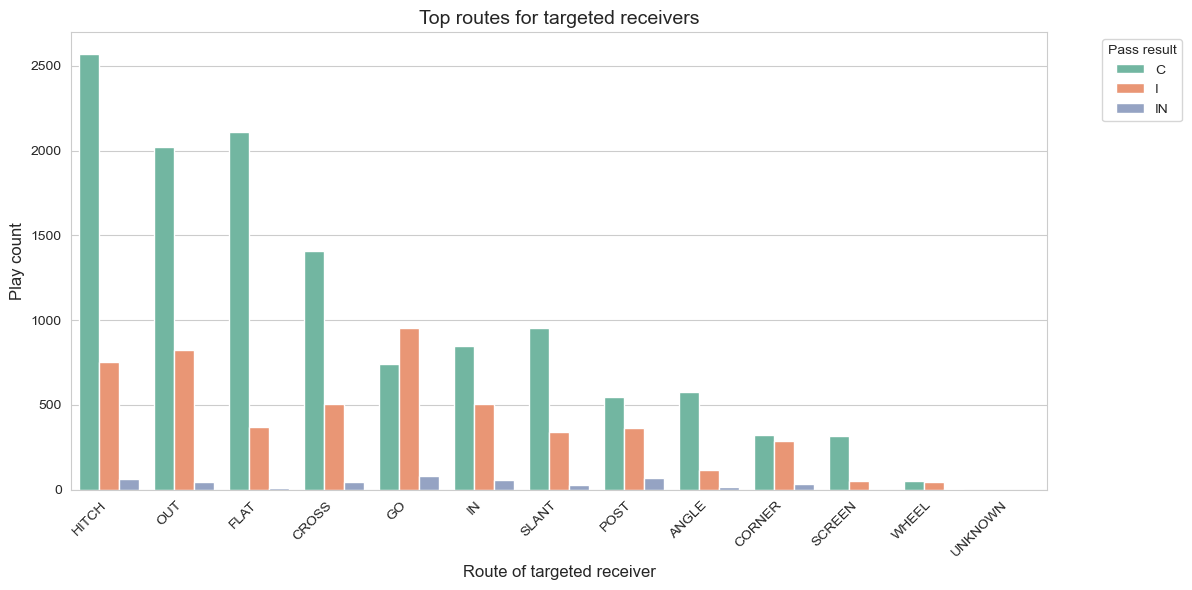

In [291]:
if not plays.empty:
    if 'pass_result' in plays.columns:
        order = plays['pass_result'].value_counts().index
        plt.figure()
        sns.countplot(data=plays, x='pass_result', order=order, palette='viridis')
        plt.title('Pass result distribution')
        plt.xlabel('Pass Result')
        plt.ylabel('Play count')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()
    if 'route_of_targeted_receiver' in plays.columns:
        top_routes = plays['route_of_targeted_receiver'].fillna('UNKNOWN').value_counts().head(20).index
        filt = plays[plays['route_of_targeted_receiver'].fillna('UNKNOWN').isin(top_routes)].copy()
        plt.figure(figsize=(12, 6))
        if 'pass_result' in plays.columns:
            sns.countplot(data=filt, x='route_of_targeted_receiver', hue='pass_result', order=top_routes, palette='Set2')
            plt.legend(title='Pass result', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            sns.countplot(data=filt, x='route_of_targeted_receiver', order=top_routes, color='steelblue')
        plt.title('Top routes for targeted receivers')
        plt.xlabel('Route of targeted receiver')
        plt.ylabel('Play count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


Pass result distribution:
The dataset is dominated by completed passes, with incompletions occurring substantially less often and interceptions being rare. This confirms a strong class imbalance that is consistent with typical NFL pass outcomes and reflects the underlying play-calling and quarterback risk profile.

Top routes for targeted receivers:
Targets are concentrated on short-to-intermediate routes (Hitch, Out, Flat, Cross, Slant), which account for the majority of completions and attempts. Deeper routes (Go, Post, Corner) appear less frequently and show a higher relative share of incompletions and interceptions, indicating that route depth and complexity systematically affect pass outcomes.

# ROUTE IMPACT ON EPA & YARDS
Using the play-level table (plays), we group plays by route of the targeted receiver and pass result. For each route–result combination, we compute:
	•	the number of unique play_id values in that group, and
	•	the mean of expected_points_added (and yards_gained, when available).

We then sort these groups by the number of plays and visualize the average EPA for the 25 most frequent route–result combinations, stratified by pass result.

,route_of_targeted_receiver,pass_result,plays,avg_yards_gained,avg_expected_points_added
15,HITCH,C,1931,9.723628,0.664752
9,FLAT,C,1657,6.423898,0.201200
21,OUT,C,1618,9.431751,0.774774
6,CROSS,C,1189,12.563121,0.925626
13,GO,I,876,0.015707,-0.933060
29,SLANT,C,841,11.007345,0.950287
18,IN,C,778,14.202830,1.283837
22,OUT,I,754,0.000000,-0.977818
16,HITCH,I,706,0.000000,-0.997972
12,GO,C,685,27.546433,2.508207


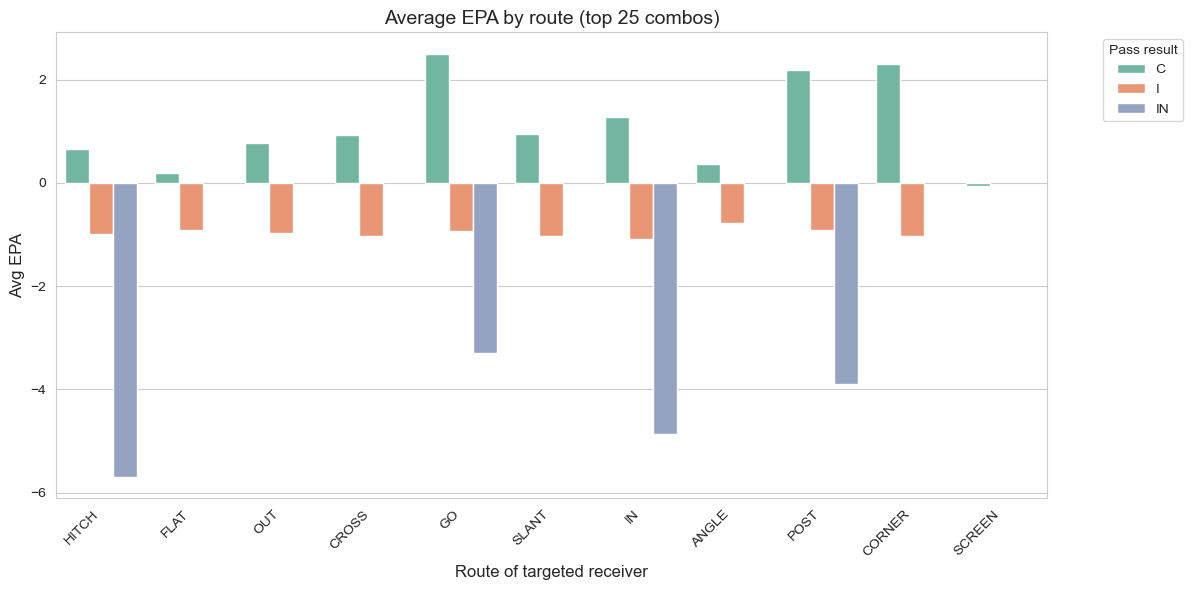

In [292]:
if not plays.empty and {'route_of_targeted_receiver', 'pass_result'}.issubset(plays.columns):
    numeric_cols = [c for c in ['yards_gained', 'expected_points_added'] if c in plays.columns]
    agg_spec = {
        'plays': ('play_id', 'nunique')
    }
    for col in numeric_cols:
        agg_spec[f'avg_{col}'] = (col, 'mean')

    route_summary = (
        plays[['route_of_targeted_receiver', 'pass_result', 'play_id'] + numeric_cols]
        .dropna(subset=['route_of_targeted_receiver'])
        .groupby(['route_of_targeted_receiver', 'pass_result'])
        .agg(**agg_spec)
        .reset_index()
        .sort_values('plays', ascending=False)
    )
    display(route_summary.head(25))

    if not route_summary.empty and 'avg_expected_points_added' in route_summary.columns:
        top_summary = route_summary.head(25)
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=top_summary,
            x='route_of_targeted_receiver',
            y='avg_expected_points_added',
            hue='pass_result',
            palette='Set2'
        )
        plt.title('Average EPA by route (top 25 combos)')
        plt.xlabel('Route of targeted receiver')
        plt.ylabel('Avg EPA')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Pass result', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


Insights from this aggregation
	
1.	Average EPA differs strongly by pass result across all routes. In the aggregated data, completions have positive mean EPA, incompletions have negative mean EPA, and interceptions have the most negative mean EPA for every route shown.
	
2.	Conditional on a completed pass, mean EPA varies across route categories. Among plays that result in completions, some routes exhibit higher average EPA than others, indicating that the distribution of EPA for completed plays is route-dependent in this dataset.
	
3.	Interceptions are associated with large negative average EPA across routes. For route–interception combinations that appear frequently enough to be plotted, the mean EPA is substantially negative relative to completions and incompletions.
	
4.	The figure reflects the most common route–result combinations. Because the plot is restricted to the 25 route–result groups with the highest play counts, the displayed averages emphasize frequent combinations and do not represent all possible routes or outcomes.

# Visualize data below for an example frame for an example play

In [293]:
if not tracking.empty:
    example = tracking.groupby(['game_id','play_id']).size().reset_index().iloc[0]
    gid, pid = int(example['game_id']), int(example['play_id'])
    play_tr = tracking[(tracking.game_id==gid)&(tracking.play_id==pid)].copy()
    print("Example play:", gid, pid, "frames:", play_tr['frame_id'].nunique())
else:
    play_tr = pd.DataFrame()

Example play: 2023090700 101 frames: 26


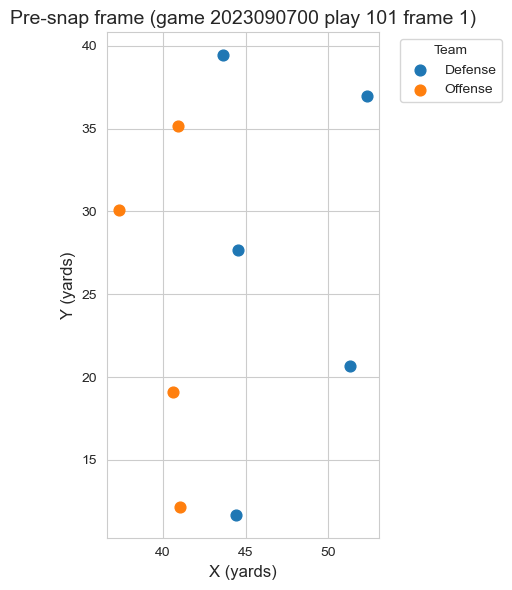

In [294]:
if not play_tr.empty:
    snap_frame = play_tr.nsmallest(1, 'frame_id')['frame_id'].iloc[0]
    snap = play_tr[play_tr['frame_id'] == snap_frame]
    fig, ax = plt.subplots(figsize=(8, 6))
    for team, grp in snap.groupby('team'):
        ax.scatter(grp['x'], grp['y'], label=team, s=60)
    ax.set_title(f'Pre-snap frame (game {gid} play {pid} frame {snap_frame})')
    ax.set_xlabel('X (yards)')
    ax.set_ylabel('Y (yards)')
    ax.set_aspect('equal', adjustable='box')
    ax.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Field heatmaps: positional density for wide receivers (WR)


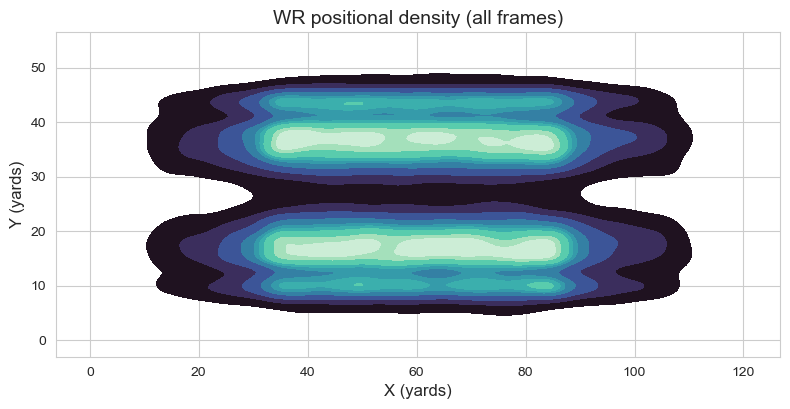

In [295]:
if not tracking.empty:
    pos_df = tracking.copy()
    pos_col = None
    for candidate in ['position', 'player_position']:
        if candidate in pos_df.columns:
            pos_col = candidate
            break
    if pos_col is None and not players.empty and 'player_id' in players.columns and 'position' in players.columns:
        pos_df = pos_df.merge(
            players[['player_id', 'position']].drop_duplicates('player_id'),
            on='player_id',
            how='left',
            suffixes=('', '_player')
        )
        if 'position_player' in pos_df.columns:
            pos_col = 'position_player'
    if pos_col:
        wr = pos_df[pos_df[pos_col] == 'WR']
        if not wr.empty:
            plt.figure(figsize=(8, 6))
            sns.kdeplot(data=wr, x='x', y='y', fill=True, cmap='mako', thresh=0.05)
            plt.title('WR positional density (all frames)')
            plt.xlabel('X (yards)')
            plt.ylabel('Y (yards)')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.tight_layout()
            plt.show()
        else:
            print('No WR frames in the loaded subset for heatmap.')
    else:
        print('Position column not available for WR heatmap.')
else:
    print('Tracking data empty; skipping WR positional heatmap.')


# Physical metrics: speeds, acceleration, change of direction


,game_id,play_id,player_id,frames,mean_speed,max_speed,mean_acc,max_acc,std_dir,mean_x,mean_y
0,2023090700,101,43290,26,0.923077,2.16,1.805385,4.27,83.698472,36.246923,30.091923
1,2023090700,101,44930,26,4.611154,7.90,2.975769,5.56,21.470646,44.842308,13.276154
2,2023090700,101,46137,26,2.212308,5.34,1.363462,2.49,15.345736,52.835385,19.949231
3,2023090700,101,52546,26,1.910000,3.17,2.445385,6.10,43.798699,46.238077,12.463846
4,2023090700,101,53487,26,2.965000,5.49,1.902692,3.31,26.717161,46.066923,25.943462


,player_role,frames,avg_speed,max_speed,avg_acc
0,Defensive Coverage,2662657,2.539118,12.53,1.804227
1,Other Route Runner,1424243,3.987556,10.33,2.598887
3,Targeted Receiver,396914,3.991578,10.34,2.692330
2,Passer,396765,1.800543,8.74,1.927069


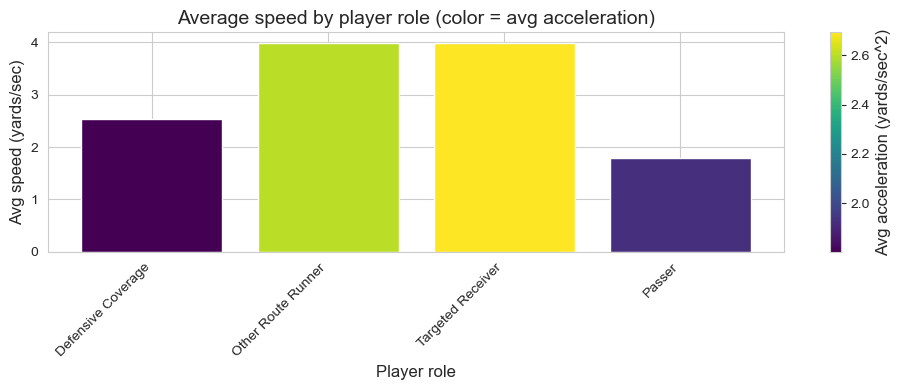

In [296]:
agg = tracking.groupby(['game_id', 'play_id', 'player_id']).agg(
    frames=('frame_id', 'nunique'),
    mean_speed=('s', 'mean'),
    max_speed=('s', 'max'),
    mean_acc=('a', 'mean'),
    max_acc=('a', 'max'),
    std_dir=('dir', 'std'),
    mean_x=('x', 'mean'),
    mean_y=('y', 'mean')
).reset_index()
display(agg.head())

if 'player_role' in tracking.columns:
    role_metrics = (
        tracking.groupby('player_role')
        .agg(
            frames=('frame_id', 'count'),
            avg_speed=('s', 'mean'),
            max_speed=('s', 'max'),
            avg_acc=('a', 'mean')
        )
        .reset_index()
        .sort_values('frames', ascending=False)
    )
    display(role_metrics)
    fig, ax = plt.subplots(figsize=(10, 4))
    norm = plt.Normalize(role_metrics['avg_acc'].min(), role_metrics['avg_acc'].max())
    colors = plt.cm.viridis(norm(role_metrics['avg_acc'].values))
    ax.bar(role_metrics['player_role'], role_metrics['avg_speed'], color=colors)
    ax.set_title('Average speed by player role (color = avg acceleration)')
    ax.set_xlabel('Player role')
    ax.set_ylabel('Avg speed (yards/sec)')
    ax.set_xticklabels(role_metrics['player_role'], rotation=45, ha='right')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Avg acceleration (yards/sec^2)')
    fig.tight_layout()
    plt.show()


# JOIN features to plays (example)


In [297]:
if not agg.empty and not plays.empty:
    per_play_speed = agg.groupby(['game_id','play_id']).agg(play_max_speed=('max_speed','max'),
                                                          play_mean_speed=('mean_speed','mean')).reset_index()
    plays = plays.merge(per_play_speed, on=['game_id','play_id'], how='left')
    print("plays merged with play speed features. shape:", plays.shape)
    display(plays[['game_id','play_id','play_max_speed','play_mean_speed']].head())

plays merged with play speed features. shape: (18009, 43)


,game_id,play_id,play_max_speed,play_mean_speed
0,2023090700,3461,8.13,3.469274
1,2023090700,461,8.10,3.211137
2,2023090700,1940,8.23,3.033357
3,2023090700,1711,7.94,3.240414
4,2023090700,1588,9.13,3.720179


# Clustering
Represent each player's route as sampled (x,y) sequence for first N frames after snap, flatten, PCA and KMeans. Here we extract pre-defined window of frames after snap (e.g., first 15 frames after snap) for players in pass plays


In [298]:
WINDOW = 15

def extract_route_vectors(tracking_df, window=WINDOW, filter_playtype='pass'):
    if tracking_df.empty:
        return pd.DataFrame()
    # define snapshot frame as minimum frameId per play (approx: first frame)
    first_frames = tracking_df.groupby(['game_id','play_id'])['frame_id'].min().reset_index().rename(columns={'frame_id':'startFrame'})
    df = tracking_df.merge(first_frames, on=['game_id','play_id'], how='left')
    df['relFrame'] = df['frame_id'] - df['startFrame']
    df_window = df[df['relFrame'].between(0, window-1)]
    # pivot to get x,y for each relFrame as columns
    df_window['x_r'] = df_window['x']
    df_window['y_r'] = df_window['y']
    pivot_x = df_window.pivot_table(index=['game_id','play_id','player_id'], columns='relFrame', values='x_r')
    pivot_y = df_window.pivot_table(index=['game_id','play_id','player_id'], columns='relFrame', values='y_r')
    # flatten
    pivot_x.columns = [f'x_{c}' for c in pivot_x.columns]
    pivot_y.columns = [f'y_{c}' for c in pivot_y.columns]
    route_vec = pd.concat([pivot_x, pivot_y], axis=1).reset_index()
    # drop rows with many NaNs
    route_vec = route_vec.dropna(thresh=int(route_vec.shape[1]*0.6))
    return route_vec

route_vec = extract_route_vectors(tracking)
print("route vectors shape:", route_vec.shape)
display(route_vec.head())

route vectors shape: (173150, 33)


,game_id,play_id,player_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14
0,2023090700,101,43290,37.36,37.36,37.35,37.34,37.33,37.31,37.26,37.15,37.01,36.84,36.65,36.45,36.23,36.03,35.83,30.07,30.07,30.07,30.07,30.07,30.07,30.08,30.08,30.09,30.10,30.11,30.12,30.13,30.14,30.14
1,2023090700,101,44930,41.03,41.03,41.05,41.07,41.11,41.20,41.33,41.54,41.79,42.12,42.50,42.94,43.42,43.95,44.52,12.17,12.17,12.18,12.20,12.22,12.26,12.33,12.42,12.53,12.68,12.84,13.01,13.20,13.38,13.57
2,2023090700,101,46137,51.32,51.35,51.39,51.43,51.48,51.58,51.65,51.73,51.82,51.92,52.04,52.16,52.31,52.48,52.67,20.69,20.66,20.63,20.61,20.58,20.63,20.62,20.60,20.59,20.58,20.57,20.53,20.46,20.38,20.28
3,2023090700,101,52546,44.42,44.51,44.59,44.66,44.74,44.82,44.92,45.03,45.16,45.30,45.47,45.67,45.90,46.17,46.45,11.69,11.70,11.71,11.73,11.76,11.81,11.86,11.94,12.04,12.15,12.26,12.39,12.52,12.66,12.79
4,2023090700,101,53487,44.56,44.63,44.70,44.76,44.81,44.86,44.90,44.95,45.01,45.08,45.17,45.28,45.41,45.58,45.78,27.66,27.67,27.69,27.70,27.71,27.70,27.68,27.63,27.55,27.44,27.28,27.09,26.87,26.61,26.32


# PCA + KMeans on route vectors


In [299]:
if not route_vec.empty:
    features = route_vec.drop(columns=['game_id','play_id','player_id']).fillna(0).values
    scaler = StandardScaler()
    feats_s = scaler.fit_transform(features)
    pca = PCA(n_components=10, random_state=42)
    pca_feats = pca.fit_transform(feats_s)
    print("Explained var ratio (first 10):", pca.explained_variance_ratio_.cumsum()[:10])
    # KMeans
    kmeans = KMeans(n_clusters=6, random_state=42)
    clusters = kmeans.fit_predict(pca_feats)
    route_vec['cluster'] = clusters
    display(route_vec[['game_id','play_id','player_id','cluster']].head())


Explained var ratio (first 10): [0.4945445  0.98743817 0.99475056 0.99670726 0.99808806 0.9988052
 0.99917981 0.99940719 0.99958574 0.99972463]


,game_id,play_id,player_id,cluster
0,2023090700,101,43290,0
1,2023090700,101,44930,3
2,2023090700,101,46137,3
3,2023090700,101,52546,3
4,2023090700,101,53487,0


# Visualize cluster centers (project to 2D)


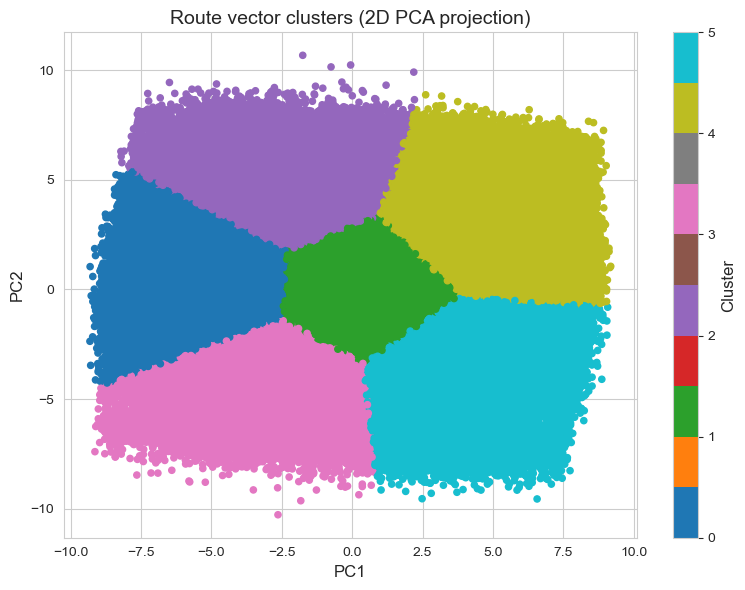

In [300]:
if not route_vec.empty:
    pca2 = PCA(n_components=2, random_state=42)
    proj2 = pca2.fit_transform(scaler.transform(route_vec.drop(columns=['game_id','play_id','player_id','cluster']).fillna(0)))
    df_proj = pd.DataFrame(proj2, columns=['pc1','pc2'])
    df_proj['cluster'] = route_vec['cluster'].values
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_proj['pc1'], df_proj['pc2'], c=df_proj['cluster'], cmap='tab10', s=20)
    plt.title('Route vector clusters (2D PCA projection)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    cbar = plt.colorbar(scatter, ticks=sorted(df_proj['cluster'].unique()))
    cbar.set_label('Cluster')
    plt.tight_layout()
    plt.show()


# CLUSTER PROFILES: average speed & separation by cluster


,cluster,mean_speed,max_speed,mean_acc,frames
0,0,2.533269,4.461173,2.010958,28.087443
1,1,2.543715,4.461823,1.950112,28.995198
2,2,3.159848,5.434015,2.167672,27.995738
3,3,3.135775,5.396681,2.164286,27.723922
4,4,2.948668,5.100568,2.130655,28.138911
5,5,2.956211,5.102551,2.132038,28.124427


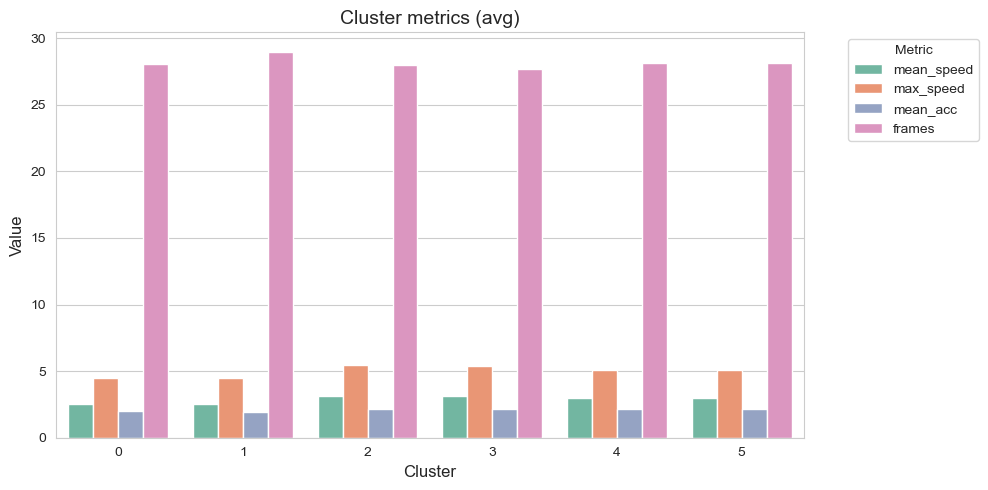

In [301]:
if not route_vec.empty and not agg.empty:
    # link by game_id, playId, playerId
    prof = route_vec.merge(agg, on=['game_id','play_id','player_id'], how='left')
    cluster_profile = prof.groupby('cluster').agg({
        'mean_speed':'mean','max_speed':'mean','mean_acc':'mean','frames':'mean'
    }).reset_index()
    display(cluster_profile)
    # bar plot
    cluster_profile_m = cluster_profile.melt(id_vars='cluster', var_name='metric', value_name='value')
    plt.figure(figsize=(10, 5))
    sns.barplot(data=cluster_profile_m, x='cluster', y='value', hue='metric', palette='Set2')
    plt.title('Cluster metrics (avg)')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# BALL LANDING VS TARGETED RECEIVER
Align tracking data for the flagged target (`player_to_predict`) with the ball landing coordinates
to quantify spatial error at the catch point across routes and outcomes.

,game_id,play_id,week,displayName,route_of_targeted_receiver,pass_result,ball_distance_error
0,2023112604,1588,12,Deonte Banks,SCREEN,C,2.191073
1,2023112604,1588,12,DeVante Parker,SCREEN,C,0.962549
2,2023112604,1355,12,Kayshon Boutte,SCREEN,C,0.586941
3,2023112604,1355,12,Deonte Banks,SCREEN,C,0.707743
4,2023091712,81,2,Xavien Howard,SCREEN,C,2.480726
5,2023091712,81,2,DeVante Parker,SCREEN,C,0.810247
6,2023091712,2480,2,DeVante Parker,SCREEN,C,0.732462
7,2023091712,2480,2,Eli Apple,SCREEN,C,3.101048
8,2023092410,2619,3,Marco Wilson,SCREEN,C,3.785248
9,2023092410,2619,3,CeeDee Lamb,SCREEN,C,0.786384


,route_of_targeted_receiver,pass_result,plays,mean_error,median_error
15,HITCH,C,6562,2.947004,2.512300
21,OUT,C,4637,5.974064,5.872180
9,FLAT,C,3501,4.844541,4.778807
6,CROSS,C,3234,6.404685,5.736976
13,GO,I,2877,13.529691,13.119634
18,IN,C,2695,4.422994,4.022735
29,SLANT,C,2439,3.534469,3.533270
12,GO,C,2314,11.354647,10.305901
22,OUT,I,2048,6.932962,6.708912
24,POST,C,2043,6.857539,5.650292


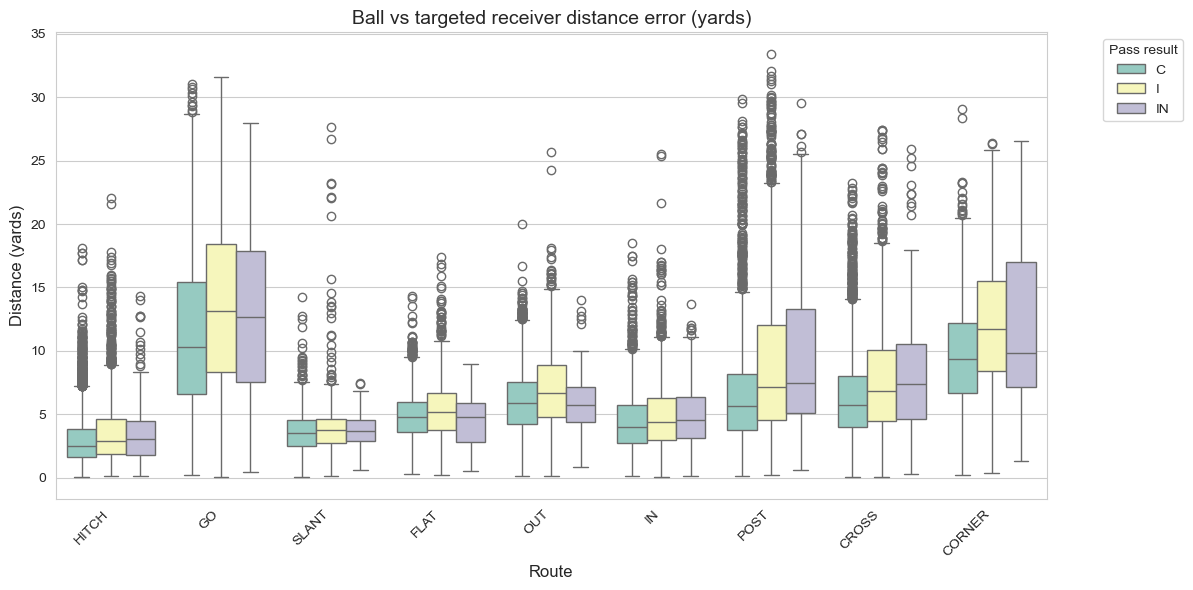

In [302]:
if not tracking.empty and not ball_targets.empty and 'player_to_predict' in tracking.columns:
    targeted_tracks = tracking[tracking['player_to_predict']].copy()
    if targeted_tracks.empty:
        print('No targeted players found in the loaded subset.')
    else:
        targeted_last = targeted_tracks.sort_values('frame_id').groupby(['game_id', 'play_id', 'player_id', 'week']).tail(1)
        ball_last = ball_targets.sort_values('frame_id').groupby(['game_id', 'play_id', 'player_id', 'week']).tail(1)
        ball_last = ball_last.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
        targeted_last = targeted_last.rename(columns={'x': 'player_x', 'y': 'player_y'})
        arrival = targeted_last.merge(
            ball_last[['game_id', 'play_id', 'player_id', 'week', 'ball_x', 'ball_y']],
            on=['game_id', 'play_id', 'player_id', 'week'],
            how='inner'
        )
        arrival['ball_dx'] = arrival['ball_x'] - arrival['player_x']
        arrival['ball_dy'] = arrival['ball_y'] - arrival['player_y']
        arrival['ball_distance_error'] = np.sqrt(arrival['ball_dx']**2 + arrival['ball_dy']**2)

        if not plays.empty:
            context_cols = [c for c in ['route_of_targeted_receiver', 'pass_result', 'yards_gained'] if c in plays.columns]
            arrival = arrival.merge(
                plays[['game_id', 'play_id'] + context_cols],
                on=['game_id', 'play_id'],
                how='left'
            )
        display(arrival[['game_id', 'play_id', 'week', 'displayName', 'route_of_targeted_receiver', 'pass_result', 'ball_distance_error']].head(10))

        if 'route_of_targeted_receiver' in arrival.columns:
            route_error = (
                arrival.dropna(subset=['route_of_targeted_receiver'])
                .groupby(['route_of_targeted_receiver', 'pass_result'])
                .agg(
                    plays=('game_id', 'count'),
                    mean_error=('ball_distance_error', 'mean'),
                    median_error=('ball_distance_error', 'median')
                )
                .reset_index()
                .sort_values('plays', ascending=False)
            )
            display(route_error.head(25))
            top_routes = route_error['route_of_targeted_receiver'].head(15).tolist()
            if top_routes:
                plt.figure(figsize=(12, 6))
                sns.boxplot(
                    data=arrival[arrival['route_of_targeted_receiver'].isin(top_routes)],
                    x='route_of_targeted_receiver',
                    y='ball_distance_error',
                    hue='pass_result',
                    palette='Set3'
                )
                plt.title('Ball vs targeted receiver distance error (yards)')
                plt.xlabel('Route')
                plt.ylabel('Distance (yards)')
                plt.xticks(rotation=45, ha='right')
                plt.legend(title='Pass result', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
else:
    print('Ball landing analysis skipped; tracking or ball_targets missing.')


## Problem Statement
Let's try to examine what are the factors involved in an incomplete pass. Is it defender's closing speed that leads to a better interception of a pass and make it incomplete? If yes, what is the correlation?
 
**Intuition:** If a defender is recovering from a poor position on the field, they will most likely sprint and be out of phase instead of providing proactive coverage. By focusing on the "Ball-in-Air" window of passes, we will show that the fastest defensive sprints often signal a coverage breakdown.

To address this problem, we need the following metrics:
- **Separation distance** - How much distance is there between receiver and defender? 'Output' dataset gives us raw coordinates $(x, y)$ but not the actual velocity vectors, we have to derive the movement ourselves. First, we calculate the gap (Euclidean Separation). Then, we measure the straight-line distance between the targeted receiver $(x_t, y_t)$ and every defender $(x_d, y_d)$ on the field. $$d = \sqrt{(x_d - x_t)^2 + (y_d - y_t)^2}$$
- **Closing speed** - How fast is this gap disappearing? We look at how the separation changes from one frame to the next. Since the data captures for every 0.1 seconds, we calculate the change over time:$$v = - \frac{(d_{t} - d_{t-1})}{0.1}$$Note: We apply a negative sign here to align the math with intuition: if the gap is shrinking (a negative change in distance), it registers as a positive closing speed.
- **Out-of-phase score (or Panic Index)** - This functions as a metric to diagnose if a defender generates high closing speed after losing positional leverage (high separation). It is defined as a product of separation distance and closing speed. $$
\text{OOP Score} = \text{Separation Distance} \times \text{Closing Speed}
$$

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.patches as patches
from scipy.signal import savgol_filter as sgolay

In [2]:
base_dir = '../114239_nfl_competition_files_published_analytics_final'
train_dir = os.path.join(base_dir, 'train')

meta_df = pd.read_csv(os.path.join(base_dir, 'supplementary_data.csv'), low_memory=False)
all_weeks = []

print("Processing input and output csvs")
for week in range(1, 19):
    week_str = f"{week:02d}"
    try:
        output_path = os.path.join(train_dir, f'output_2023_w{week_str}.csv')
        week_out = pd.read_csv(output_path)
        
        input_path = os.path.join(train_dir, f'input_2023_w{week_str}.csv')
        cols = ['game_id', 'play_id', 'nfl_id', 'player_name', 'player_role', 'player_side', 'player_position']
        week_in = pd.read_csv(input_path, usecols=cols).drop_duplicates(['game_id', 'play_id', 'nfl_id'])
        
        merged = week_out.merge(week_in, on=['game_id', 'play_id', 'nfl_id'], how='left')
        all_weeks.append(merged)
        
        del week_out, week_in, merged
        gc.collect()
        
    except FileNotFoundError:
        print(f"  - Week {week_str} skipped (Expected if file doesn't exist)", end="\r") 
        continue

ball_in_air = pd.concat(all_weeks, ignore_index=True)
del all_weeks
gc.collect()

ball_in_air = ball_in_air.merge(
    meta_df[['game_id', 'play_id', 'pass_result']], 
    on=['game_id', 'play_id'], how='left'
)

print(f"All csvs merged into df. Total Frames: {len(ball_in_air):,}")

Processing input and output csvs
All csvs merged into df. Total Frames: 562,936


Calculating separation distance. Stored in `dist_smooth` column in `closest_df`

In [3]:
targets = ball_in_air[ball_in_air['player_role'] == 'Targeted Receiver'][['game_id', 'play_id', 'frame_id', 'x', 'y']]
targets = targets.rename(columns={'x': 't_x', 'y': 't_y'})
defenders = ball_in_air[ball_in_air['player_side'] == 'Defense'].copy()
analysis_df = defenders.merge(targets, on=['game_id', 'play_id', 'frame_id'], how='inner')

# Calculating Raw Distance
analysis_df['dist'] = np.sqrt((analysis_df['x'] - analysis_df['t_x'])**2 + (analysis_df['y'] - analysis_df['t_y'])**2)

# Smoothening the distance to remove any jitters between frames
def smooth_distance(series):
    if len(series) >= 5:
        return sgolay(series, window_length=5, polyorder=2)
    return series

analysis_df['dist_smooth'] = analysis_df.groupby(['game_id', 'play_id', 'nfl_id'])['dist'].transform(smooth_distance)

# Filtering to the closest defender for each receiver
analysis_df = analysis_df.sort_values(['game_id', 'play_id', 'frame_id', 'dist_smooth'])
closest_df = analysis_df.drop_duplicates(['game_id', 'play_id', 'frame_id']).copy()

Calculating closing speed by performing derivative on the separation distance data

In [4]:
closest_df = closest_df.sort_values(['game_id', 'play_id', 'frame_id'])
closest_df['dist_chg'] = closest_df['dist_smooth'].diff()
closest_df['same_play'] = closest_df['play_id'] == closest_df['play_id'].shift(1)
closest_df.loc[~closest_df['same_play'], 'dist_chg'] = np.nan
closest_df['closing_speed'] = -(closest_df['dist_chg'] / 0.1)
closest_df['oop_score'] = closest_df['dist_smooth'] * closest_df['closing_speed']

closest_df[['player_name', 'dist', 'dist_smooth', 'closing_speed', 'oop_score']].dropna().sample(5)

,player_name,dist,dist_smooth,closing_speed,oop_score
215137,Xavier McKinney,1.262696,1.262617,2.448415,3.091411
159373,Stephon Gilmore,11.964435,11.969069,-2.246699,-26.890895
385834,Logan Wilson,3.543586,3.545175,5.350346,18.967912
216259,Nick McCloud,3.630895,3.621663,7.727183,27.985252
263970,Devon Witherspoon,1.289496,1.286482,-0.508025,-0.653565


Measuring statistical significance of this hypothesis

In [5]:
if 'yards_to_go' not in closest_df.columns:
    closest_df = closest_df.merge(
        meta_df[['game_id', 'play_id', 'yards_to_go']], 
        on=['game_id', 'play_id'], 
        how='left'
    )

print("Statistical Significance Test")
group_c = closest_df[closest_df['pass_result'] == 'C']['closing_speed'].dropna()
group_i = closest_df[closest_df['pass_result'] == 'I']['closing_speed'].dropna()

t_stat, p_val = stats.ttest_ind(group_c, group_i, equal_var=False)

print(f"Complete Pass Avg Speed (Complete): {group_c.mean():.2f} yds/s")
print(f"Incomplete Pass Avg Speed: {group_i.mean():.2f} yds/s")
print(f"Difference: {group_c.mean() - group_i.mean():.2f} yds/s")
print(f"P-Value: {p_val:.2e}")

print("\nSensitivity Test (Deep Passes > 10 Yards)")
deep_c = closest_df[(closest_df['pass_result'] == 'C') & (closest_df['yards_to_go'] > 10)]['closing_speed'].mean()
deep_i = closest_df[(closest_df['pass_result'] == 'I') & (closest_df['yards_to_go'] > 10)]['closing_speed'].mean()

print(f"Deep Pass Avg Speed (C): {deep_c:.2f}")
print(f"Deep Pass Avg Speed (I): {deep_i:.2f}")
print(f"Gap: {deep_c - deep_i:.2f}")

Statistical Significance Test
Complete Pass Avg Speed (Complete): 0.90 yds/s
Incomplete Pass Avg Speed: 0.67 yds/s
Difference: 0.23 yds/s
P-Value: 5.22e-69

Sensitivity Test (Deep Passes > 10 Yards)
Deep Pass Avg Speed (C): 1.25
Deep Pass Avg Speed (I): 0.91
Gap: 0.34


When we aggregated the maximum closing speed for every play (Weeks 1–18) and compared it against the pass result, a statistically significant pattern emerged:

* **Incompletions (Defensive Wins):** Average Max Speed = **0.67 yds/sec**
* **Completions (Defensive Losses):** Average Max Speed = **0.90 yds/sec**

### Statistical Validation
This **0.23 yds/sec difference** in speed between winning and losing plays suggests a fundamental truth about coverage. A T-test confirmed this result is statistically significant with a P-value of:
$$\text{P-value} = 5.22 \times 10^{-69}$$

### Sensitivity Analysis (Deep Passes)
This value is very tiny, confirming that the divergence in defensive speed profiles is not statistical noise but a **highly consistent and robust characteristic of NFL coverage.**

To test if this paradox holds in high-leverage situations, we isolated the **Deep Pass** category (plays where yards-to-go > 10). The disparity was even more pronounced:

* **Deep Pass Completions (Losing Plays):** 1.25 yds/sec
* **Deep Pass Incompletions (Winning Plays):** 0.91 yds/sec
* **The Final Gap:** **0.34 yds/sec**

This confirms that the "Panic Index" is most profound when the stakes are highest, where the cost of being "Out-of-Phase" requires the most drastic (and ultimately unsuccessful) recovery effort.

### Does Closing Speed Prevent Catches?
To evaluate the effectiveness of defensive speed, we aggregated the Maximum Closing Speed for every play and compared it against the play's outcome.

**The Result:**
As visualized below, Completed passes (C) feature a higher average maximum closing speed than Incomplete passes (I). This supports our hypothesis that high defensive velocity is a "lagging indicator": a symptom of a defender sprinting to recover from a lost position.

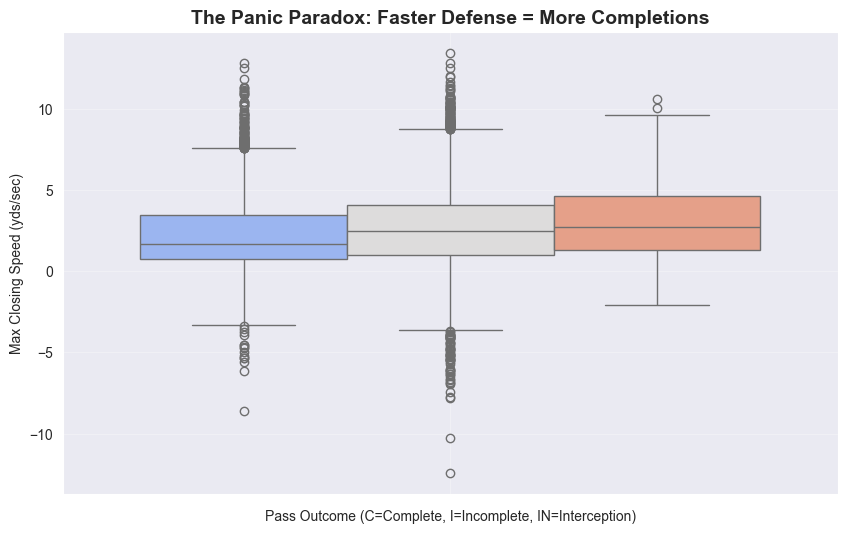

Average Max Closing Speed by Outcome:
pass_result
C     2.628208
I     2.265648
IN    3.162629
Name: closing_speed, dtype: float64


In [6]:
# Identify Max Speed per play
idx = closest_df.groupby(['game_id', 'play_id'])['closing_speed'].idxmax()
play_max_speed = closest_df.loc[idx].copy()

if 'pass_result' not in play_max_speed.columns:
    play_max_speed = play_max_speed.merge(
        ball_in_air[['game_id', 'play_id', 'pass_result']].drop_duplicates(), 
        on=['game_id', 'play_id']
    )

plt.figure(figsize=(10, 6))
sns.boxplot(data=play_max_speed, hue='pass_result', y='closing_speed', palette='coolwarm', legend=False)

plt.title("The Panic Paradox: Faster Defense = More Completions", fontsize=14, fontweight='bold')
plt.ylabel("Max Closing Speed (yds/sec)")
plt.xlabel("Pass Outcome (C=Complete, I=Incomplete, IN=Interception)")
plt.grid(True, alpha=0.3)

plt.savefig('panic_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Max Closing Speed by Outcome:")
print(play_max_speed.groupby('pass_result')['closing_speed'].mean())

Top 10 'Panicked' Defenders Leaderboard
 nfl_id         player_name position  oop_score
  52475       Julian Okwara      OLB  40.717062
  55999            Jay Ward       SS  34.328004
  42368       Shaq Thompson      MLB  31.124344
  54686 Tariq Castro-Fields       CB  27.980906
  52410         Chase Young      OLB  24.197449
  55043         Jake Hansen      OLB  24.071610
  47939      Justin Hollins      OLB  21.565549
  44865          Teez Tabor       FS  20.724589
  55047    Tristin McCollum       SS  18.728115
  56111           D.J. Ivey       CB  18.346510


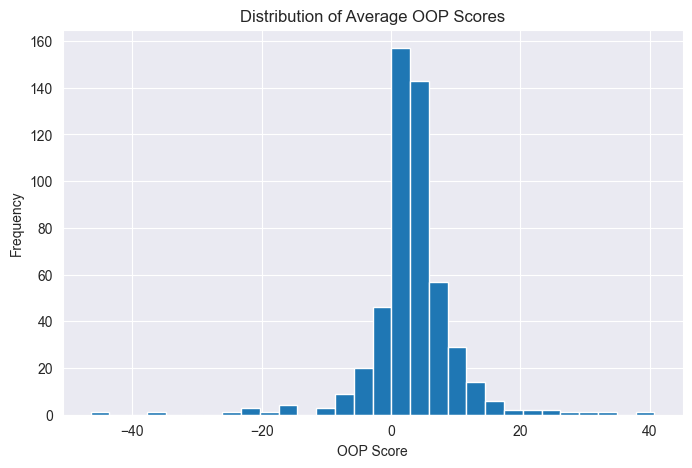

In [7]:
if 'closest_df' not in globals() or closest_df.empty:
    raise RuntimeError("closest_df not found. Please run metric calculation cell.")

# Define coverage positions (standard NFL abbreviations)
COVERAGE_POSITIONS = {'CB', 'S', 'FS', 'SS', 'LB', 'MLB', 'OLB'}

# Filter to defenders in coverage roles
coverage_df = closest_df[
    (closest_df['player_side'] == 'Defense') &
    (closest_df['player_position'].isin(COVERAGE_POSITIONS)) &
    (closest_df['oop_score'].notna())
]

# Aggregate mean OOP score per player
leaderboard = (
    coverage_df
    .groupby(['nfl_id', 'player_name', 'player_position'])['oop_score']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

leaderboard = leaderboard.rename(columns={'player_position': 'position'})

# Display top 10 panicked players
print("Top 10 'Panicked' Defenders Leaderboard")
print(leaderboard.head(10).to_string(index=False))

plt.figure(figsize=(8, 5))
plt.hist(leaderboard['oop_score'], bins=30)
plt.xlabel('OOP Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average OOP Scores')
plt.show()

### Performance based on OOP Score

The O.O.P. Score penalizes bursts of speed that occur only after a defender has already lost leverage. Rather than rewarding raw athleticism, the metric emphasizes positional efficiency shifting evaluation from volume of speed to quality of positioning.

Based on empirical analysis across the full season, we propose the following performance tiers:

| Tier | O.O.P. Score | Interpretation |
|------|--------------|----------------|
| **In-Phase** | < 15 | Controlled, proactive coverage. The defender maintains tight positioning, rendering high-speed recovery unnecessary. Reflects high technical efficiency. |
| **Recovery Mode** | 15 – 40 | The defender has lost initial leverage and is now accelerating to re-establish proximity. Competitive but reactive—common on well-executed offensive routes. |
| **Panic State** | > 40 | The defender is sprinting at high velocity (>10 yds/s) while still >4 yards from the receiver. Indicates a complete breakdown in coverage; speed is maximal but futile. |

![alt text](panic_concept_diagram_v2_clean.png "Title")

### Visualizing the "Ball-in-Air" Window

To validate that our metrics reflect real on-field dynamics,and not data artifacts. We animated the play with the **highest recorded closing speed** in our dataset (Weeks 1–9). This play exemplifies the **“Panic State”**: a defender sprinting at maximum effort while significantly out of phase with the targeted receiver.

The animation (saved as `panic_play_enhanced.gif`) includes:
- **All offensive and defensive players**, colored red and blue respectively,
- The **targeted receiver** highlighted with a gold star,
- The **closest defender** (as identified by our O.O.P. pipeline) marked in cyan,
- A **dashed white line** connecting the two to visualize separation distance in real time,
- A live display of **separation distance, closing speed, and O.O.P. Score** for each frame,
- A clear label marking the **frame of peak closing speed**,
- Final play outcome (**Completion** or **Incompletion**) shown in the last few frames.

This visualization confirms that extreme closing speed in our top-ranked play occurs during a genuine recovery sprint validating both the **kinematic derivation** and the **diagnostic power** of the O.O.P. Score. 

In [15]:
def create_football_field(linenumbers=True, endzones=True, figsize=(12, 6.33)):
    fig, ax = plt.subplots(1, figsize=figsize)
    rect = patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0)
    ax.add_patch(rect)
    ax.plot([0, 0, 120, 120, 0], [0, 53.3, 53.3, 0, 0], color='white', linewidth=2)
    for x in range(10, 120, 10):
        ax.plot([x, x], [0, 53.3], color='white', alpha=0.5, linewidth=1)
    for x in range(10, 120):
        if x % 10 == 0:
            continue
        ax.plot([x, x], [53.3 - 1, 53.3], color='white', alpha=0.5)
        ax.plot([x, x], [0, 1], color='white', alpha=0.5)
        ax.plot([x, x], [23, 24], color='white', alpha=0.5)
        ax.plot([x, x], [29.3, 30.3], color='white', alpha=0.5)
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x if x <= 50 else 120 - x
            ax.text(x, 5, str(numb), ha='center', fontsize=20, color='white')
            ax.text(x, 53.3 - 5, str(numb), ha='center', fontsize=20, color='white', rotation=180)
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)
        ez2 = patches.Rectangle((110, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.set_xlim(0, 120)
    ax.set_ylim(-5, 58.3)
    ax.axis('off')
    return fig, ax

top_play_row = closest_df.sort_values('closing_speed', ascending=False).iloc[0]
test_game_id = int(top_play_row['game_id'])
test_play_id = int(top_play_row['play_id'])
max_speed_frame = int(top_play_row['frame_id'])

outcome = meta_df[
    (meta_df['game_id'] == test_game_id) & 
    (meta_df['play_id'] == test_play_id)
]['pass_result'].iloc[0]

print(f"Animating 'Top Panic' Play: Game {test_game_id}, Play {test_play_id}")
print(f"Outcome: {'Completion' if outcome == 'C' else 'Incompletion'}")
print(f"Max Closing Speed at Frame: {max_speed_frame}")

play_tracking = ball_in_air[
    (ball_in_air['game_id'] == test_game_id) & 
    (ball_in_air['play_id'] == test_play_id)
].copy()

# Get frames (Ball-in-Air window only)
frames_to_use = sorted(play_tracking['frame_id'].unique())
last_frame = frames_to_use[-1]

target_info = play_tracking[play_tracking['player_role'] == 'Targeted Receiver'][['frame_id', 'x', 'y']].set_index('frame_id')

oop_play = closest_df[
    (closest_df['game_id'] == test_game_id) &
    (closest_df['play_id'] == test_play_id)
][['frame_id', 'dist_smooth', 'closing_speed', 'oop_score', 'player_name']].set_index('frame_id')

def animate_play_enhanced(df, target_info, oop_play, frames, max_speed_frame, outcome, last_frame):
    fig, ax = create_football_field()
    
    off_scatter = ax.scatter([], [], c='red', s=100, label='Offense', zorder=5, edgecolors='white')
    def_scatter = ax.scatter([], [], c='blue', s=100, label='Defense', zorder=5, edgecolors='white')
    target_scatter = ax.scatter([], [], c='gold', s=200, marker='*', label='Targeted Receiver', zorder=6, edgecolors='black')
    closest_scatter = ax.scatter([], [], c='cyan', s=180, edgecolors='black', linewidth=2, zorder=7)
    
    sep_line, = ax.plot([], [], color='white', linestyle='--', linewidth=2, alpha=0.7, zorder=4)
    
    info_txt = ax.text(10, 50, '', fontsize=11, color='white', fontweight='bold',
                       bbox=dict(facecolor='black', alpha=0.6))
    max_speed_txt = ax.text(60, 50, '', fontsize=13, color='orange', fontweight='bold',
                            bbox=dict(facecolor='black', alpha=0.7), visible=False)
    outcome_txt = ax.text(60, 45, '', fontsize=12, color='lime' if outcome == 'C' else 'white',
                          fontweight='bold', bbox=dict(facecolor='black', alpha=0.7), visible=False)
    
    ax.legend(loc='upper right')
    
    def update(frame):
        current = df[df['frame_id'] == frame]
        off_data = current[current['player_side'] == 'Offense']
        def_data = current[current['player_side'] == 'Defense']
        
        off_scatter.set_offsets(off_data[['x', 'y']].values if not off_data.empty else np.empty((0, 2)))
        def_scatter.set_offsets(def_data[['x', 'y']].values if not def_data.empty else np.empty((0, 2)))
        
        if frame in target_info.index:
            rx, ry = target_info.loc[frame, ['x', 'y']]
            target_scatter.set_offsets([[rx, ry]])
        else:
            target_scatter.set_offsets(np.empty((0, 2)))
        
        if frame in oop_play.index:
            row = oop_play.loc[frame]
            dist = row['dist_smooth']
            speed = row['closing_speed']
            oop = row['oop_score']
            d_name = row['player_name']
            
            def_pos = current[(current['player_side'] == 'Defense') & (current['player_name'] == d_name)]
            if not def_pos.empty:
                dx, dy = def_pos.iloc[0]['x'], def_pos.iloc[0]['y']
                closest_scatter.set_offsets([[dx, dy]])
                if frame in target_info.index:
                    rx, ry = target_info.loc[frame, ['x', 'y']]
                    sep_line.set_data([dx, rx], [dy, ry])
                else:
                    sep_line.set_data([], [])
            else:
                closest_scatter.set_offsets(np.empty((0, 2)))
                sep_line.set_data([], [])
            
            info_txt.set_text(
                f"Frame: {frame}\n"
                f"Separation: {dist:.1f} yds\n"
                f"Closing Speed: {speed:.1f} yds/s\n"
                f"OOP Score: {oop:.1f}"
            )
        else:
            closest_scatter.set_offsets(np.empty((0, 2)))
            sep_line.set_data([], [])
            info_txt.set_text(f"Frame: {frame}\n— No OOP data —")
        
        # Highlight max speed frame
        if frame == max_speed_frame:
            max_speed_txt.set_text("MAX CLOSING SPEED")
            max_speed_txt.set_visible(True)
        else:
            max_speed_txt.set_visible(False)
        
        # Show outcome in last 3 frames
        if frame >= last_frame - 2:
            outcome_txt.set_text("COMPLETION" if outcome == 'C' else "INCOMPLETION")
            outcome_txt.set_visible(True)
        else:
            outcome_txt.set_visible(False)
        
        return off_scatter, def_scatter, target_scatter, closest_scatter, sep_line, info_txt, max_speed_txt, outcome_txt

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=False, repeat=False)
    plt.close()
    return anim

anim = animate_play_enhanced(
    play_tracking,
    target_info,
    oop_play,
    frames_to_use,
    max_speed_frame,
    outcome,
    last_frame
)

anim.save('panic_play_enhanced.gif', writer='pillow', fps=10)
print("Animation saved for panic play")

# Display in notebook
HTML(anim.to_jshtml())

Animating 'Top Panic' Play: Game 2023100107, Play 4000
Outcome: Completion
Max Closing Speed at Frame: 2
Animation saved for panic play


### Conclusion

The Out-of-Phase Score (or Panic Index) presents evaluation method for defensive plays: the fastest moments often reveal the deepest flaws. By quantifying when speed is a symptom of being “Out of Phase,” it shifts focus from raw athleticism to **positional intelligence** a critical but often overlooked dimension of coverage quality.

Future work should prioritize using the O.O.P. Score for predictive frameworks for real-time coaching and broadcast applications.